<a href="https://colab.research.google.com/github/Pranav-2509/NIGHT_VISION_SELF/blob/main/NeuralODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
!pip install torchdi f feq

ERROR: Could not find a version that satisfies the requirement torchdi (from versions: none)
ERROR: No matching distribution found for torchdi


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
%matplotlib inline

#Euler Method

In [3]:
def euler(func, t, dt, y):
  return dt * func(t, y)

#Neural ODE

In [4]:
class NeuralODE(nn.Module):

  def __init__(self, func):
    super().__init__()
    self.func = func                      #The Neural Network which predicts the gradient

  def forward(self, y0, t, solver):
    solution = torch.empty(len(t), *y0.shape, dtype=y0.dtype, device=y0.device)    #To store all the calculated values of y(t)
    solution[0] = y0

    j = 1
    for t0, t1 in zip(t[:-1], t[1:]):    #zip produces all pairs of adjacent 't'
      dy = euler(self.func, t0, t1 - t0, y0)
      y1 = y0 + dy
      solution[j] = y1
      j += 1
      y0 = y1

    return solution

#Derivative=Cos(t), should plot Sin(t)

In [5]:
y0 = torch.Tensor([0])
t = torch.linspace(0., 6 * np.pi, 1500)   #'t' values to evaluate y at

class cos(nn.Module):

  def forward(self, t, y):
    return torch.cos(t)

In [6]:
ode_test = NeuralODE(func=cos())
test_result = ode_test(y0=y0, t=t, solver=euler)

# make sure you transpose
test_result = test_result.transpose(0, 1)

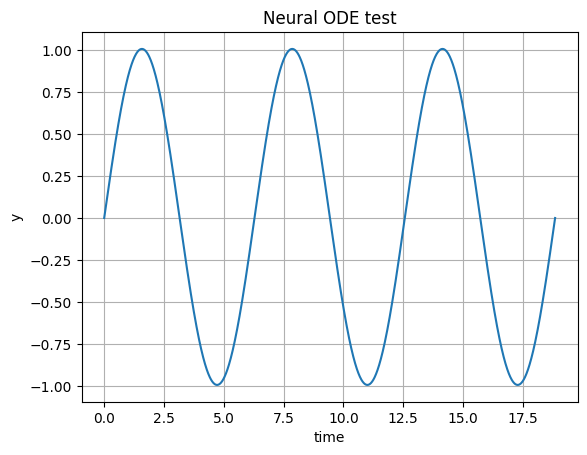

In [7]:
# visualize result
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Neural ODE test')

ax.set_xlabel('time')
ax.set_ylabel('y')

ax.plot(t.numpy(), test_result[0].numpy())

plt.grid(True)
plt.show()

#Preparing our toy dataset

In [8]:
# Set the data size
data_size = 2000

# Generate toy dataset
true_y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., data_size)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])


# Define the neural ODE function
class Lambda(nn.Module):
  def forward(self, t, y):
    return torch.mm(y**3, true_A)

# Create and solve the neural ODE
with torch.no_grad():
  node = NeuralODE(func=Lambda())
  true_y = node(y0=true_y0, t=t, solver=euler)

In [9]:
print (true_y.shape)
print (true_y)

torch.Size([2000, 1, 2])
tensor([[[2.0000, 0.0000]],

        [[1.9900, 0.2001]],

        [[1.9799, 0.3972]],

        ...,

        [[0.0610, 0.5035]],

        [[0.0578, 0.5034]],

        [[0.0546, 0.5032]]])


#Plotting the Toy Dataset

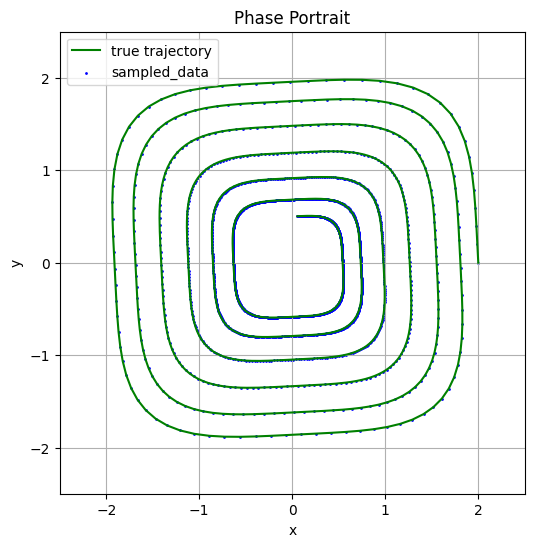

In [10]:
import matplotlib.pyplot as plt

def visualize(true_y, pred_y=None):
  fig = plt.figure(figsize=(6, 6), facecolor='white')
  ax = fig.add_subplot(111)

  ax.set_title('Phase Portrait')
  ax.set_xlabel('x')
  ax.set_ylabel('y')

  ax.plot(true_y.numpy()[:,0, 0], true_y.numpy()[:,0,  1], 'green', label='true trajectory')
  ax.scatter (true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], color = 'blue', label = 'sampled_data', s=1)

  if pred_y is not None:
    ax.plot(pred_y.numpy()[:,0, 0], pred_y.numpy()[:,0, 1], 'red', label='learned trajectory')

  ax.set_xlim(-2.5, 2.5)
  ax.set_ylim(-2.5, 2.5)

  plt.legend()
  plt.grid(True)
  plt.show()

# Example usage
visualize(true_y)

In [11]:

# s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time),  size=batch_size, replace=False))

# batch_y0 = true_y[s]  # (batch_size, 1, emb)
# batch_t = t[:batch_time]  # (T)
# batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)

In [12]:
batch_time = 10
batch_size = 16

def get_batch():


  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time),  size=batch_size, replace=False))

  batch_y0 = true_y[s]  # (batch_size, 1, emb)
  batch_t = t[:batch_time]  # (T)
  batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)

  return batch_y0, batch_t, batch_y


In [13]:
batch_y0, batch_t, batch_y = get_batch()


In [14]:
print(batch_y.shape)


torch.Size([10, 16, 1, 2])


In [15]:
class ODEFunc(nn.Module):

  def __init__(self):
    super().__init__()

    # TO-DO: Make your own ODE network!
    self.net = nn.Sequential(
      nn.Linear(2, 50),
      nn.Tanh(),
      nn.Linear(50, 2)
    )

    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y**3)
    return output

  0%|          | 0/401 [00:00<?, ?it/s]

Iter 0000 | Total Loss 3.804765


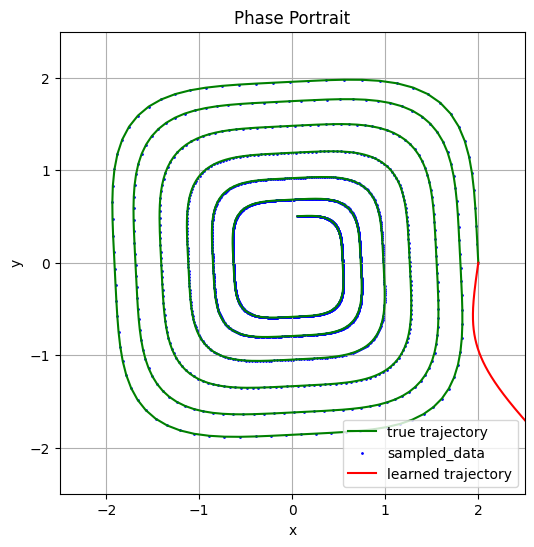

Iter 0050 | Total Loss 0.759946


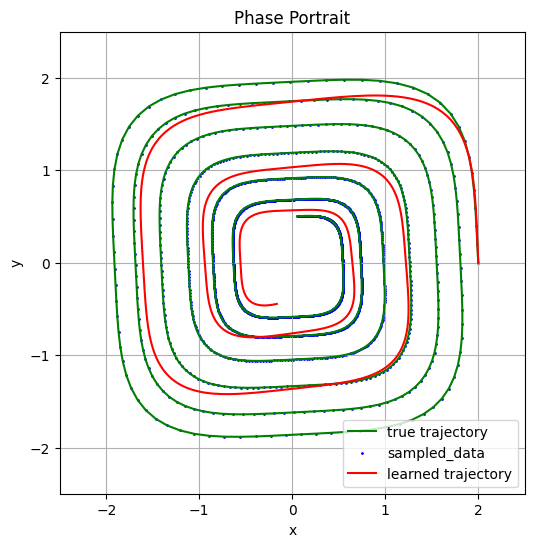

Iter 0100 | Total Loss 0.584278


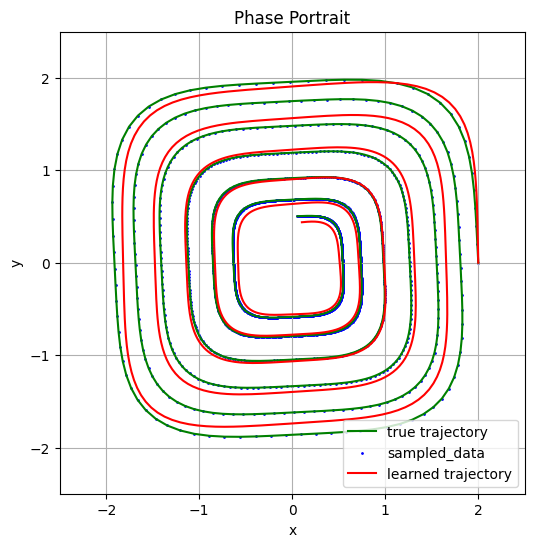

Iter 0150 | Total Loss 0.880738


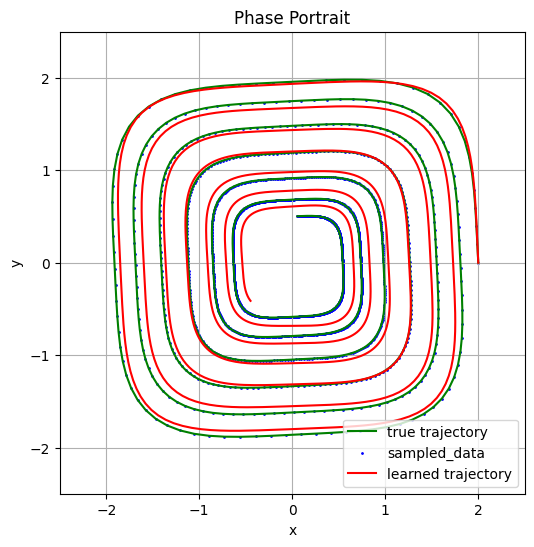

Iter 0200 | Total Loss 0.769297


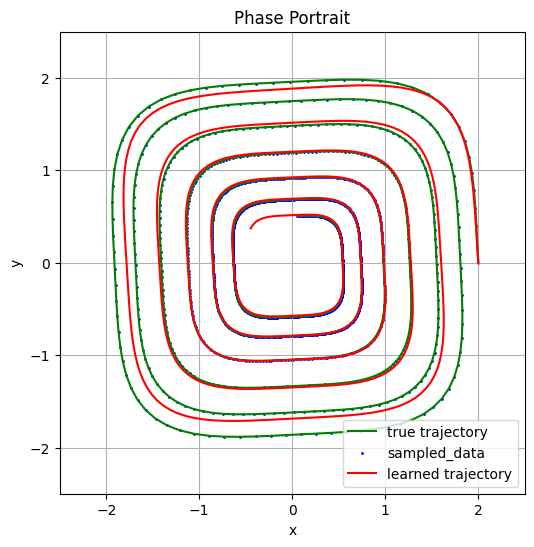

Iter 0250 | Total Loss 0.912515


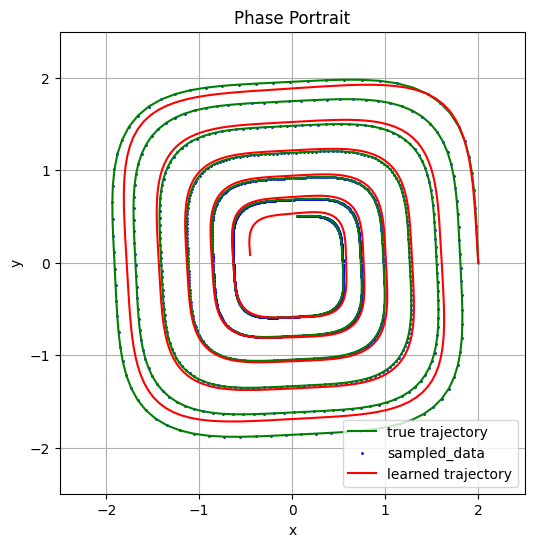

Iter 0300 | Total Loss 0.764534


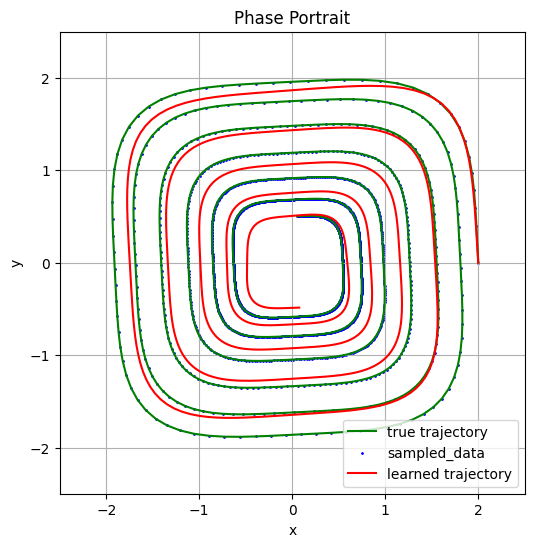

Iter 0350 | Total Loss 1.070638


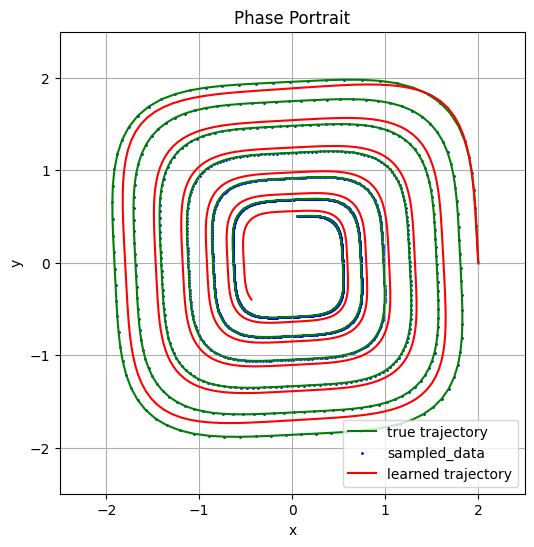

Iter 0400 | Total Loss 0.732414


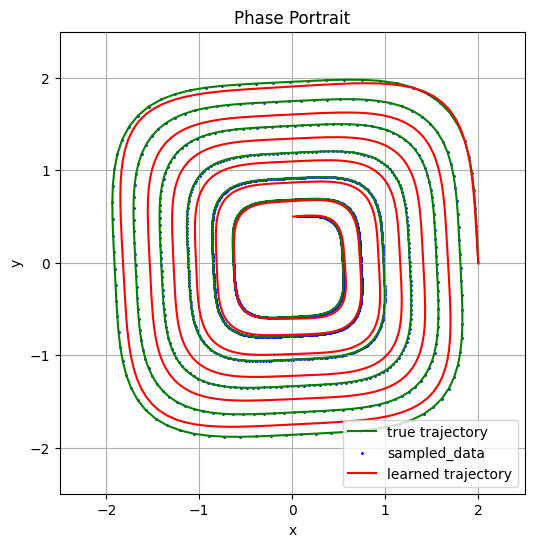

Process time: 9.58826208114624 sec


In [16]:
# Train
niters = 400

node = NeuralODE(func=ODEFunc())
optimizer = optim.RMSprop(node.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()

  batch_y0, batch_t, batch_y = get_batch()
  pred_y = node(y0=batch_y0, t=batch_t, solver=euler)
  loss = torch.mean(torch.abs(pred_y - batch_y))

  loss.backward()
  optimizer.step()

  if iter % 50 == 0:
    with torch.no_grad():
      pred_y = node(true_y0, t, solver=euler)
      loss = torch.mean(torch.abs(pred_y - true_y))
      print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))

      visualize(true_y, pred_y)

end_time = time.time() - start_time
print('Process time: {} sec'.format(end_time))